# Supervised Top Model Training

This notebook is an example of how you can do the supervised top model training in the eUniRep low-N pipeline. It will walk you through tuning of a L2 regression model.

### Setup the notebook
Install required packages, mount google drive folder and define util functions.

In [1]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install optuna
!pip install biopython
!pip install seaborn

  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-cjpap5ic
  Running command git clone -q https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-cjpap5ic
  Created wheel for jax-unirep: filename=jax_unirep-0.1-cp36-none-any.whl size=67744670 sha256=8dc0c374a5836de2468424ca4f77d4a59b58d7cc4b97c53ed65b8377f81da308
  Stored in directory: /tmp/pip-ephem-wheel-cache-u87rahwr/wheels/08/4d/ac/6e75862c118d1ad82122f410859524b20190ce7a821b76ffcd
Successfully built jax-unirep
     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 35.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 112kB 43.

In [2]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params_1900
from Bio import SeqIO
import pandas as pd
import glob
import os
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import feather

from google.colab import drive

drive.mount('/content/drive/')
gdrive_path = "/content/drive/My Drive/Colab Notebooks/UniRep2/"
!ls "/content/drive/My Drive/Colab Notebooks/UniRep2"

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning:

No GPU/TPU found, falling back to CPU.



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
2MS2_weights  feathers	pca_analysis.ipynb  top_training.ipynb
BLAC_weights  inputs	PETase_weights


In [0]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(gdrive_path + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data

# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(name):
    seqs = np.loadtxt(gdrive_path + name + '_seqs.txt', dtype='str')
    
    fitnesses = np.loadtxt(gdrive_path + name + '_fitness.txt')
    data = []
    for seq, fitness in zip(seqs, fitnesses):
        data.append([str(seq).strip(), fitness])
    
    return data

# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


aa_to_int = {
  'M':1,
  'R':2,
  'H':3,
  'K':4,
  'D':5,
  'E':6,
  'S':7,
  'T':8,
  'N':9,
  'Q':10,
  'C':11,
  'U':12,
  'G':13,
  'P':14,
  'A':15,
  'V':16,
  'I':17,
  'F':18,
  'Y':19,
  'W':20,
  'L':21,
  'O':22, #Pyrrolysine
  'X':23, # Unknown
  'Z':23, # Glutamic acid or GLutamine
  'B':23, # Asparagine or aspartic acid
  'J':23, # Leucine or isoleucine
  'start':24,
  'stop':25,
}


def get_int_to_aa():
  return {value:key for key, value in aa_to_int.items()}


def _one_hot(x, k, dtype=np.float32):
  # return np.array(x[:, None] == np.arange(k), dtype)
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def distance_matrix(N):
	distance_matrix = np.zeros((N,N))
	for i in range(N):
		for j in range(N):
			# distance_matrix[i,j]=1- ((abs(i-j)/N)**2)
			distance_matrix[i,j]= 1-(abs(i-j)/N)

	return distance_matrix


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)
  # dist_mat = distance_matrix(N)
  # confusion_matrix = confusion_matrix*dist_mat
  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

### Load in sequences, get representations then save them
This section of code will load in sequence and fitness files, get various representations of them, then save them as .feather formats. If you already have the .feather formats you can save computation time by going straight to the next section.

Note that this is computationally the heaviest section to run (passing sequences through the mLSTM implemented in JAX-unirep).

In [0]:
# load labeled training data
seqs_df = pd.DataFrame(read_labeled_data('inputs/blac'), columns = ['sequence', 'fitness'])

In [0]:
# define key params
DIR_PATH = gdrive_path + 'BLAC_weights/'

PARAMS = [None, 'one_hot', 'blac_unirep_global_init_1']

# get representations of data for each params:
N_seqs = len(seqs_df)
print("N_seqs:", N_seqs)

# vary batches based on memory available (i.e. if you have less memory run more batches)
# this google colab can handle around 1000 seqs per batch for sure
N_BATCHES = 6

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

for param in PARAMS:
  # append path to param unless unirep (no param)
  if param == 'one_hot':
    print('getting reps for one hot')
    onehot = multi_onehot(seqs_df.sequence)
    feat_cols = [ 'feat' + str(j) for j in range(1, onehot.shape[1] + 1) ]
    this_df = pd.DataFrame(onehot, columns=feat_cols)
    this_df.insert(0, "sequence", seqs_df.sequence)
    this_df.insert(1, "fitness", seqs_df.fitness)

    save_reps(this_df, gdrive_path + 'one_hot')

    continue

  elif param is None:
    name = 'unirep'

  else:
    name = param
    param = load_params_1900(DIR_PATH + param)

  print('getting reps for', name)

  # get 1st sequence
  reps, _, _ = get_reps(seqs_df.sequence[0], params=param)
  feat_cols = [ 'feat' + str(j) for j in range(1, reps.shape[1] + 1) ]
  this_df = pd.DataFrame(reps, columns=feat_cols)
  this_df.insert(0, "sequence", seqs_df.sequence[0])
  this_df.insert(1, "fitness", seqs_df.fitness[0])

  # get the rest in batches
  for i in range(N_BATCHES):
    this_unirep, _, _ = get_reps(seqs_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ] , params=param)
    this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
    this_unirep_df.insert(0, "sequence", seqs_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
    this_unirep_df.insert(1, "fitness", seqs_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
    this_df = pd.concat([this_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

  save_reps(this_df, gdrive_path + name)



N_seqs: 5469
getting reps for unirep
/content/drive/My Drive/Colab Notebooks/UniRep2/unirep.feather saved!
getting reps for one hot
/content/drive/My Drive/Colab Notebooks/UniRep2/one_hot.feather saved!
getting reps for blac_unirep_global_init_1
/content/drive/My Drive/Colab Notebooks/UniRep2/blac_unirep_global_init_1.feather saved!


###Load Reps
Load representations of sequences stored in .feather format, then use those representations and corresponding labels to train a top model.

In [0]:
# load the reps you want into dataframes
FEATHER_PATH = gdrive_path + 'feathers/'

unirep_df = read_reps(FEATHER_PATH + 'BLAC_unirep')
eunirep_df = read_reps(FEATHER_PATH + 'BLAC_eunirep')
onehot_df = read_reps(FEATHER_PATH + 'BLAC_one_hot')

dfs = [unirep_df, eunirep_df, onehot_df]
df_names = ['unirep', 'eunirep', 'one hot']

# Model Selection

We will try select various simple top models.

### Ridge Regularization hyperparameter tuning
The first model to try is ridge regression (linear regression + squared error + L2 regularization), evaluated by MSE.

This section helps with hyperparameter tuning for the alpha parameter selection (L2 regularization strength).


<Figure size 432x288 with 0 Axes>

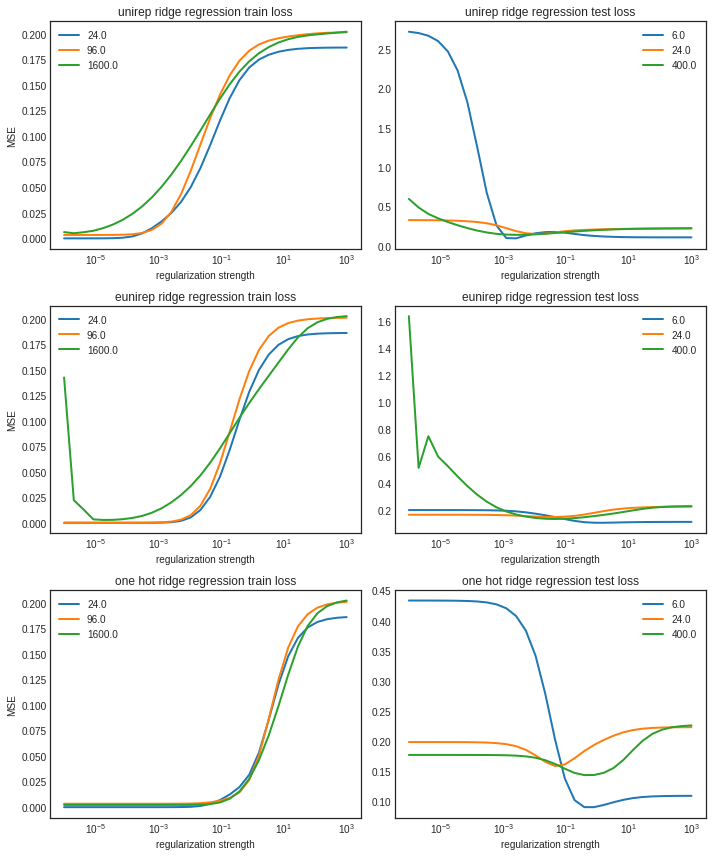

In [5]:
# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(dfs[0].shape[0])

BATCH_SIZES = [24, 96, 1600]
batch_size_list = (np.array(BATCH_SIZES)/0.8).astype("int")

plt.clf()

fig = plt.figure(figsize=(10,4*len(dfs)))
plt.style.use('seaborn-white')

for i in range(len(dfs)):
  ax1 = fig.add_subplot(len(dfs),2,(2*i+1), title=df_names[i] + " ridge regression train loss")
  ax2 = fig.add_subplot(len(dfs),2,(2*i+2), title=df_names[i] + " ridge regression test loss")

  df = dfs[i]
  for batch_size in batch_size_list:

    X = df.loc[rndperm[:batch_size], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size], "fitness"]

    alpha_vals = np.logspace(-6,3,30)
    alpha_list = []
    train_loss_list = []
    test_loss_list = []

    for alpha_i in alpha_vals:

      # train-test split for both 
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

      # ridge regression model setup
      kfold = KFold(n_splits=10, random_state=42, shuffle=True)

      model = RidgeCV(alphas=[alpha_i], cv=kfold)

      # fit the model
      model.fit(X_train, Y_train)

      # predict fitness to get train and test losses
      Y_train_preds = model.predict(X_train)
      Y_test_preds = model.predict(X_test)

      # train_loss = np.linalg.norm(Y_train_preds - Y_train)
      # test_loss = np.linalg.norm(Y_test_preds - Y_test)
      train_loss = np.mean((Y_train_preds - Y_train)**2)
      test_loss = np.mean((Y_test_preds - Y_test)**2)

      alpha_list.append(model.alpha_)
      train_loss_list.append(train_loss)
      test_loss_list.append(test_loss)

    # plot train and test losses
    ax1.plot(alpha_list, train_loss_list,linewidth=2)
    ax2.plot(alpha_list, test_loss_list,linewidth=2)

  ax1.legend(batch_size_list*0.8)
  ax1.set_xscale("log")
  ax1.set_xlabel("regularization strength")
  ax1.set_ylabel("MSE")
  ax2.legend(batch_size_list*0.2)
  ax2.set_xscale("log")
  ax2.set_xlabel("regularization strength")
  ax1.set_ylabel("MSE")

plt.tight_layout()
plt.show()


Pick your alpha, now lets see how it actually performs. Based on this dataset we picked the following alphas:

<Figure size 432x288 with 0 Axes>

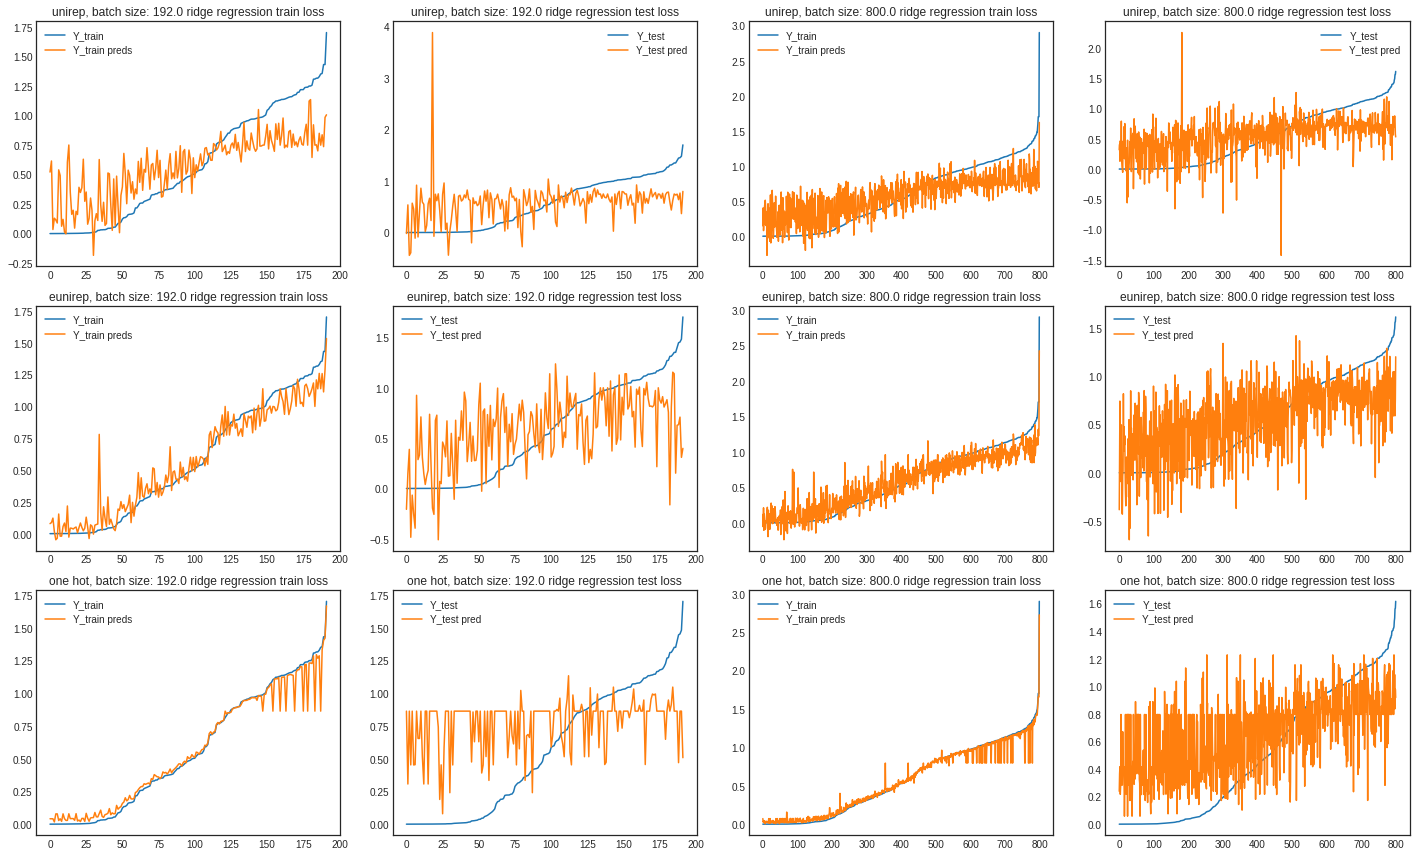

In [6]:
ALPHAS = [0.01, 0.01, 0.1]

BATCH_SIZES = [96*2, 800]
SPLIT = 0.5

batch_size_list = (np.array(BATCH_SIZES)/SPLIT).astype("int")

# randomly select subset of sequence as input data
np.random.seed(1717)
rndperm = np.random.permutation(dfs[0].shape[0])

plt.clf()

fig = plt.figure(figsize=(10*len(BATCH_SIZES) ,4*len(dfs)))
plt.style.use('seaborn-white')

for i in range(len(dfs)):

  df = dfs[i]
  for j in range(len(batch_size_list)):

    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]

    # train-test split for both 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT, random_state=1717)

    # ridge regression model setup
    kfold = KFold(n_splits=10, random_state=1717, shuffle=True)

    model = RidgeCV(alphas=[ALPHAS[i]], cv=kfold)

    # fit the model
    model.fit(X_train, Y_train)

    # predict fitness to get train and test losses
    Y_train_preds = model.predict(X_train)
    Y_test_preds = model.predict(X_test)

    # train_loss = np.linalg.norm(Y_train_preds - Y_train)
    # test_loss = np.linalg.norm(Y_test_preds - Y_test)
    train_loss = np.mean((Y_train_preds - Y_train)**2)
    test_loss = np.mean((Y_test_preds - Y_test)**2)

    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+1), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*(1-SPLIT)) + " ridge regression train loss")
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
    ax1.legend(['Y_train','Y_train preds'])

    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+2), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*SPLIT) + " ridge regression test loss")
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
    ax2.legend(['Y_test','Y_test pred'])

plt.tight_layout()
plt.show()


### ridge regression improvement over random sampling 
Test top model function in the same way as done in Supplementary Figure 2 of the Low-N engineering paper (but for 2MS2 instead of avGFP; and instead of training on Sarkisyan and testing on SynNeigh and FP Homologs, this trains and tests on random splits of the same dataset)

The purpose of doing this despite the clearly good fit function for Ridge Regression (see above) is for use as a comparision for datasets that may look less ideal (i.e. <96 training data points)



unirep [0.7758620689655172, 0.6837606837606838, 0.9049773755656108, 0.7860262008733625, 1.0, 0.625, 1.1282051282051282, 0.8530805687203791, 0.6451612903225806, 0.8333333333333333, 0.8294930875576038, 0.6097560975609757, 1.0576923076923077, 0.851063829787234, 0.8928571428571429, 0.7766990291262136, 1.0084033613445378, 0.689655172413793, 0.24242424242424243, 0.972972972972973] Mean Score: 0.8083211946741808
eunirep [1.7241379310344829, 1.794871794871795, 1.176470588235294, 1.572052401746725, 1.0, 2.0833333333333335, 1.0256410256410255, 1.4218009478672984, 1.6129032258064515, 1.0714285714285714, 0.6451612903225806, 2.073170731707317, 1.346153846153846, 1.3829787234042552, 0.9821428571428572, 1.3592233009708736, 1.4285714285714286, 0.689655172413793, 2.0606060606060606, 1.0810810810810811] Mean Score: 1.3765692156169531
one hot [1.120689655172414, 1.2820512820512822, 1.3574660633484161, 1.0480349344978166, 0.8181818181818182, 1.3541666666666667, 1.3333333333333333, 1.1374407582938388, 1.50

<Figure size 432x288 with 0 Axes>

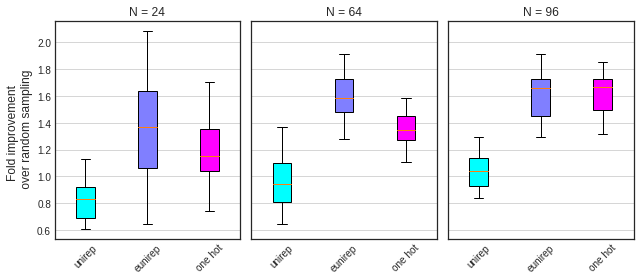

In [7]:
# number of batches to test
N_BATCH = 20

# number of sequences per training batch
TRAIN_BATCH_SIZES = [24, 64, 96]

# number of random trials to perform for baseline
N_RAND_BATCHES = 20

# wild-type fitness
WT_FIT = 0.63481905


batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:

  # number of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = RidgeCV(alphas=[ALPHAS[j]], cv=kfold)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))
    params_level.append(scores_level)

  batch_level.append(params_level)


plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()



### Testing other top models
If you see good performance using ridge regression great! Remember that good performance on these test sets are not going to be fully indicative of performance during directed evolution (see report for details). For example, in the cell above for our 2MS2 dataset a more appropriate test would be to train on a low-N subset from the single mutant dataset, then to test on a subset from the double mutants dataset.

Changing model is super simple if it what you are trying to implement is built into sklearn - just substitute the model = ... line with your new model! Remember every new model with increased complexity will have new hyperparameters that need to be manually tuned.

The paper tries ensembling their ridge regression so we can try that too. Note, code is not included in this cleaned up notebook but it is very easy to plug in any other simple regression functions available on sklearn i.e. L1, Huber, etc. We tried several without significant improvements in fitting results for our datasets.

<Figure size 432x288 with 0 Axes>

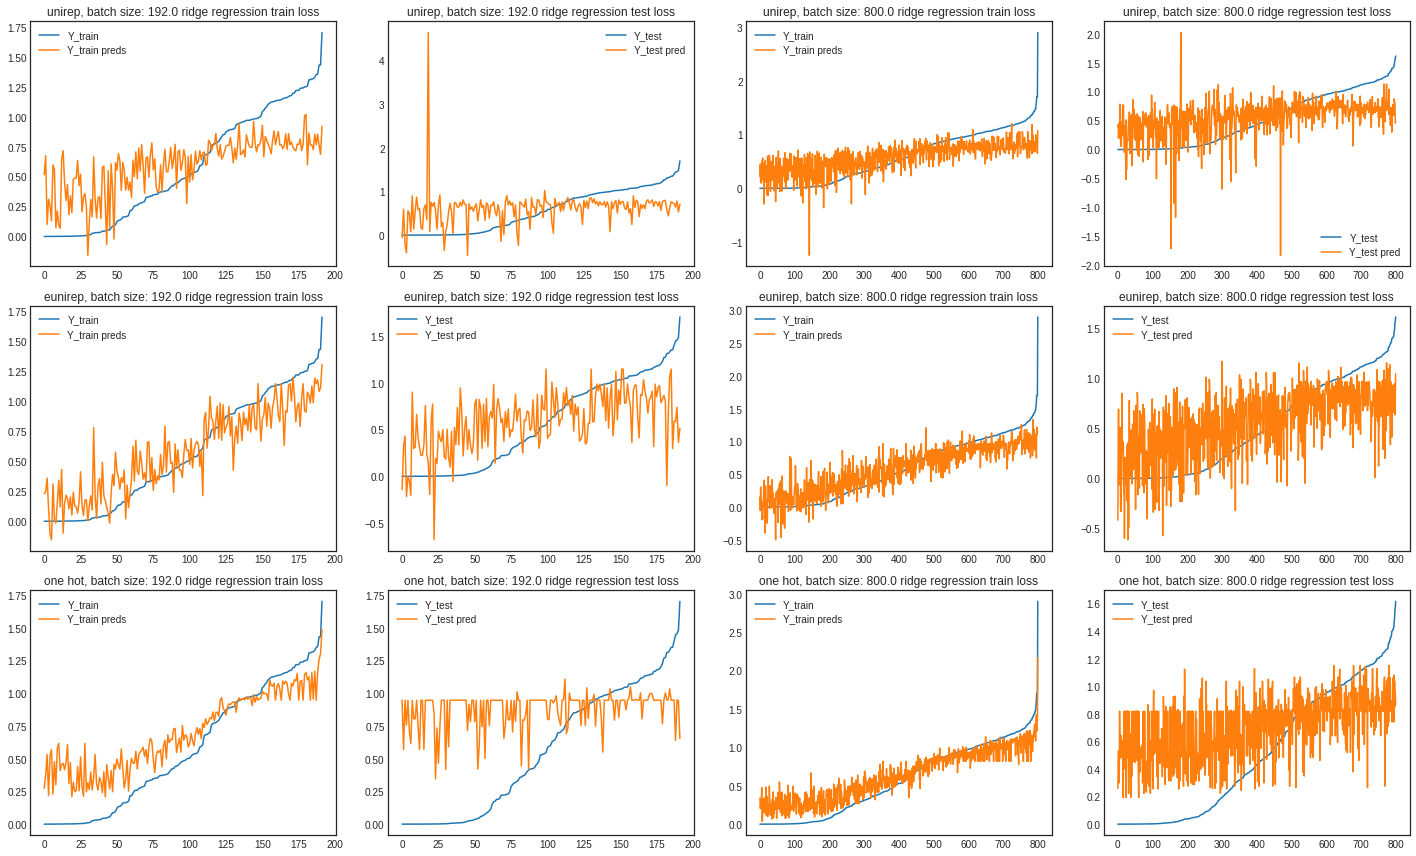

In [11]:
# Ensemble Ridge Regression
from sklearn.ensemble import BaggingRegressor

ALPHAS = [0.01, 0.01, 0.1]

BATCH_SIZES = [96*2, 800]
SPLIT = 0.5

batch_size_list = (np.array(BATCH_SIZES)/SPLIT).astype("int")

# randomly select subset of sequence as input data
np.random.seed(1717)
rndperm = np.random.permutation(dfs[0].shape[0])

plt.clf()

fig = plt.figure(figsize=(10*len(BATCH_SIZES) ,4*len(dfs)))
plt.style.use('seaborn-white')

for i in range(len(dfs)):

  df = dfs[i]
  for j in range(len(batch_size_list)):

    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]

    # train-test split for both 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT, random_state=1717)

    # ridge regression model setup
    kfold = KFold(n_splits=10, random_state=1717, shuffle=True)

    model = BaggingRegressor(base_estimator=RidgeCV(alphas=[ALPHAS[j]], cv=kfold), n_estimators=20, max_samples=0.9, max_features=0.9, random_state=42)

    # fit the model
    model.fit(X_train, Y_train)

    # predict fitness to get train and test losses
    Y_train_preds = model.predict(X_train)
    Y_test_preds = model.predict(X_test)

    # train_loss = np.linalg.norm(Y_train_preds - Y_train)
    # test_loss = np.linalg.norm(Y_test_preds - Y_test)
    train_loss = np.mean((Y_train_preds - Y_train)**2)
    test_loss = np.mean((Y_test_preds - Y_test)**2)

    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+1), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*(1-SPLIT)) + " ridge regression train loss")
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
    ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
    ax1.legend(['Y_train','Y_train preds'])

    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(4*i+2*j+2), title=df_names[i] + ", batch size: " + str(batch_size_list[j]*SPLIT) + " ridge regression test loss")
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
    ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
    ax2.legend(['Y_test','Y_test pred'])

plt.tight_layout()
plt.show()

unirep [0.7758620689655172, 0.9401709401709403, 0.5429864253393665, 0.6986899563318778, 1.0909090909090908, 0.625, 1.0256410256410255, 0.7582938388625592, 1.182795698924731, 0.8333333333333333, 0.7373271889400922, 0.7317073170731708, 0.9615384615384615, 0.7446808510638298, 0.7142857142857143, 0.48543689320388345, 0.9243697478991596, 0.689655172413793, 0.24242424242424243, 0.6486486486486487] Mean Score: 0.7676878307984719
eunirep [1.896551724137931, 1.623931623931624, 1.176470588235294, 1.572052401746725, 1.0, 2.291666666666667, 1.0256410256410255, 1.5165876777251184, 1.5053763440860215, 1.0714285714285714, 0.7373271889400922, 2.3170731707317076, 1.5384615384615383, 1.276595744680851, 0.7142857142857143, 1.5533980582524272, 1.5126050420168067, 0.8866995073891625, 2.0606060606060606, 1.1891891891891893] Mean Score: 1.4232973919076264
one hot [1.206896551724138, 1.2820512820512822, 1.3574660633484161, 1.0480349344978166, 0.8181818181818182, 1.3541666666666667, 1.3333333333333333, 1.13744

<Figure size 432x288 with 0 Axes>

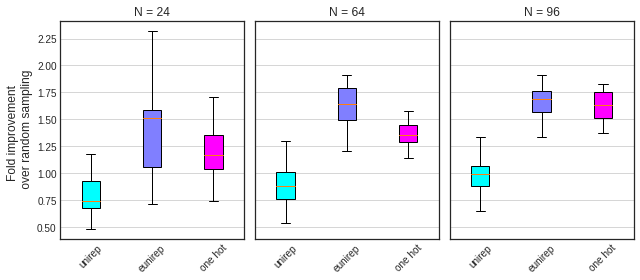

In [12]:
# number of batches to test
N_BATCH = 20

# number of sequences per training batch
TRAIN_BATCH_SIZES = [24, 64, 96]

# number of random trials to perform for baseline
N_RAND_BATCHES = 20

# wild-type fitness
WT_FIT = 0.63481905


batch_level = []
for TRAIN_BATCH_SIZE in TRAIN_BATCH_SIZES:

  # number of sequences per holdout batch
  HOLDOUT_BATCH_SIZE = TRAIN_BATCH_SIZE*10

  params_level = []
  for j in range(len(dfs)):
    df = dfs[j]

    scores_level = []
    for i in range(N_BATCH):
      # change random seed for each batch
      np.random.seed(42*(i+2))
      rndperm = np.random.permutation(df.shape[0])

      # data setup
      X = df.loc[rndperm[0:TRAIN_BATCH_SIZE], df.columns[2:]]
      Y = df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

      X_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], df.columns[2:]]
      Y_holdout = df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

      # ridge regression model setup
      kfold = KFold(n_splits=10, shuffle=True)

      model = BaggingRegressor(base_estimator=RidgeCV(alphas=[ALPHAS[j]], cv=kfold), n_estimators=20, max_samples=0.9, max_features=0.9, random_state=42)

      # fit the model
      model.fit(X, Y)

      # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
      Y_preds = model.predict(X_holdout)

      usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:int(HOLDOUT_BATCH_SIZE/10)]

      # Note: wild-type fitness = WT_FIT (thats the scoring metric)
      usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])

      # randomly shuffle holdout set RAND_BATCHES time
      # and take average of top TRAIN_BATCH_SIZE fitness
      avg_rand_count = 0
      for k in range(N_RAND_BATCHES):
        np.random.seed(42*(i+2) + (1+k))
        rand_Y = np.random.permutation(np.array(Y_holdout))[:int(HOLDOUT_BATCH_SIZE/10)]
        avg_rand_count += np.sum([1 if i > WT_FIT else 0 for i in rand_Y])
      avg_rand_count /= N_RAND_BATCHES

      # final score ratio:
      scores_level.append(usorted_count/avg_rand_count)

    print(df_names[j], scores_level, "Mean Score:", np.mean(scores_level))
    params_level.append(scores_level)

  batch_level.append(params_level)


plt.clf()
ax_dict = {}
fig, axes = plt.subplots(nrows=1, ncols=len(TRAIN_BATCH_SIZES), sharey=True, figsize=(3*len(TRAIN_BATCH_SIZES),4))

for i in range(len(TRAIN_BATCH_SIZES)):
  ax_dict[i] = axes[i].boxplot(np.array(batch_level[i]).transpose(), showfliers=False,patch_artist=True)
  axes[i].set_title("N = "+str(TRAIN_BATCH_SIZES[i]))
  axes[i].set_xticklabels(df_names,rotation=45)
  
axes[0].set_ylabel("Fold improvement \n over random sampling",size = 12)

color_idx = np.linspace(0, 1, len(df_names))
for ax_ind in range(len(ax_dict)):
  for patch, i in zip(ax_dict[ax_ind]['boxes'], color_idx):
    patch.set_facecolor(plt.cm.cool(i))

for ax in axes:
    ax.yaxis.grid(True)

plt.tight_layout()
plt.show()



#### 2D plotting for 2 hyperparameters to optimize
Huber loss is used as an arbitrary example (it was selected for testing as we see a lot of outliers in our ridge regresson)

In [0]:
# HUBER LOSS
np.random.seed(42)
rndperm = np.random.permutation(unirep_df.shape[0])

BATCH_SIZES = [24, 96, 1600]
batch_size_list = (np.array(BATCH_SIZES)/0.8).astype("int")

plt.clf()

fig = plt.figure(figsize=(15,3*len(dfs)))
plt.style.use('seaborn-white')

for i in range(len(dfs)):

  df = dfs[i]
  for j in range(len(batch_size_list)):

    X = df.loc[rndperm[:batch_size_list[j]], df.columns[2:]]
    Y = df.loc[rndperm[:batch_size_list[j]], "fitness"]

    alpha_vals = np.logspace(-6,6,30)
    eps_vals = np.linspace(1.0,5.0,10)
    train_loss_mat = np.zeros((len(alpha_vals), len(eps_vals)))
    test_loss_mat = np.zeros((len(alpha_vals), len(eps_vals)))

    for k in range(len(alpha_vals)):
      for l in range(len(eps_vals)):

        # train-test split for both 
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        # ridge regression model setup
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        model = HuberRegressor(epsilon=eps_vals[l], alpha=alpha_vals[k])

        # fit the model
        model.fit(X_train, Y_train)

        # predict fitness to get train and test losses and update matrices
        train_loss_mat[k,l] = model.score(X_train, Y_train)
        test_loss_mat[k,l] = model.score(X_test, Y_test)

    # plot train and test losses
    ax1 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(5*i+2*j+1), title=df_names[i] + " " + str(batch_size_list[j]*0.8) + " Huber regression train loss")
    sns.heatmap(train_loss_mat, ax=ax1)
    ax2 = fig.add_subplot(len(dfs),len(BATCH_SIZES)*2,(5*i+2*j+1), title=df_names[i] + " " + str(batch_size_list[j]*0.2) + " Huber regression train loss")
    sns.heatmap(test_loss_mat, ax=ax2)

plt.tight_layout()
plt.show()